In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dateutil.parser import parse
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,5)

In [2]:
data = pd.read_csv("Stock_Price.csv", parse_dates=['Date'], index_col='Date')
data.head(10)

,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2000-03-27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
2000-03-28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2000-03-29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
2000-03-30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
2000-03-31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600
...,...,...,...,...,...,...
2017-08-31,112.820000,113.790001,112.440002,113.660004,113.660004,1091400
2017-09-01,113.790001,114.099998,112.790001,113.309998,113.309998,950000
2017-09-05,112.519997,113.529999,111.160004,111.870003,111.870003,1805200


In [3]:
df_resam = data.resample('D').mean()
df = df_resam.bfill()
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj_Close    0
Volume       0
dtype: int64

Text(0.5, 1.0, 'Closing')

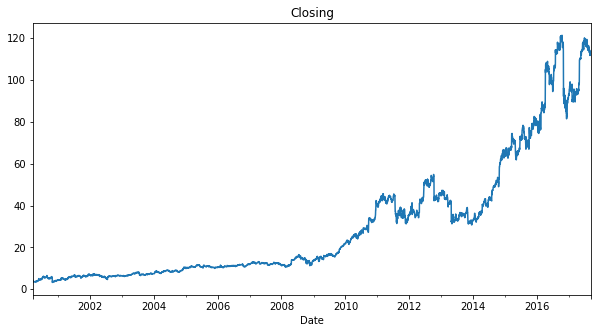

In [4]:
df.Close.plot()
plt.title("Closing")

In [17]:
def prepare_dataset(data, size):
  x_data = []
  y_data = []

  l = len(data) - size

  for i in range(l):
    x = data[i:i+size]
    y = data[i+size]
    x_data.append(x)
    y_data.append(y)

  return np.array(x_data), np.array(y_data)

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(data.Close.values.reshape(-1,1))

In [7]:
train_size = int(np.ceil(len(scaled_data) * 0.8))
train_size

3514

In [9]:
len(scaled_data)

4392

In [18]:
xtrain, ytrain = prepare_dataset(scaled_data[:train_size], 10)
xtest, ytest = prepare_dataset(scaled_data[train_size:], 10)

In [19]:
print(xtrain.shape[0], ytrain.shape[0])
print(xtest.shape[0], ytest.shape[0])

3504 3504
868 868


In [20]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (xtrain.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

r = model.fit(xtrain, ytrain, epochs = 50, batch_size = 100)

Epoch 1/50
36/36 [==============================] - 5s 40ms/step - loss: 0.0034
Epoch 2/50
36/36 [==============================] - 1s 40ms/step - loss: 1.1164e-04
Epoch 3/50
36/36 [==============================] - 1s 39ms/step - loss: 7.4801e-05
Epoch 4/50
36/36 [==============================] - 1s 40ms/step - loss: 6.8325e-05
Epoch 5/50
36/36 [==============================] - 1s 39ms/step - loss: 6.7524e-05
Epoch 6/50
36/36 [==============================] - 1s 40ms/step - loss: 6.8727e-05
Epoch 7/50
36/36 [==============================] - 1s 40ms/step - loss: 6.8611e-05
Epoch 8/50
36/36 [==============================] - 1s 39ms/step - loss: 7.5263e-05
Epoch 9/50
36/36 [==============================] - 1s 40ms/step - loss: 8.3686e-05
Epoch 10/50
36/36 [==============================] - 1s 39ms/step - loss: 7.8440e-05
Epoch 11/50
36/36 [==============================] - 1s 39ms/step - loss: 6.1891e-05
Epoch 12/50
36/36 [==============================] - 1s 40ms/step - loss: 6.85

In [21]:
predictions = model.predict(xtest)
predictions = scaler.inverse_transform(predictions)
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - ytest) ** 2)))
rmse


82.13608081840063

In [28]:
data_plot = df.copy()

In [51]:
# Plot the data

train = data_plot[:train_size]
valid = data_plot[train_size:]
#valid['Predictions'] = predictions
data_predict = data_plot[-868:]
data_predict['Prediction'] = predictions
data_predict.head()

,Open,High,Low,Close,Adj_Close,Volume,Prediction
Date,,,,,,,
2015-04-25,69.610001,69.709999,65.264999,65.485001,65.485001,2834000.0,36.241444
2015-04-26,69.610001,69.709999,65.264999,65.485001,65.485001,2834000.0,36.622551
2015-04-27,69.610001,69.709999,65.264999,65.485001,65.485001,2834000.0,37.041916
2015-04-28,65.455002,65.730003,64.125000,64.949997,64.949997,3504400.0,37.412933
2015-04-29,64.875000,65.489998,64.500000,64.980003,64.980003,2316600.0,37.537838


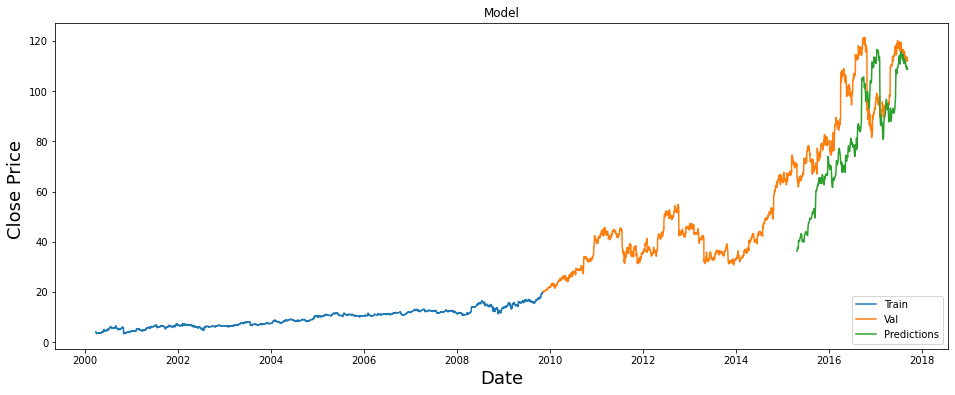

In [52]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price ', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(data_predict['Prediction'])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

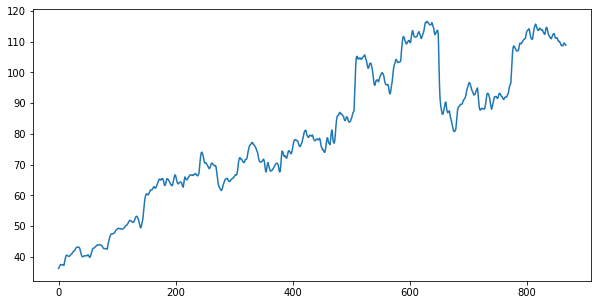

In [49]:
plt.plot(predictions)
plt.show()